# SETUP

The code cells below contains necessary imports, util functions, and global variables that are used throughout the noteboook

In [1]:
import os
import csv
import ast
import itertools
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# util functions
import utils

# display floating points in pandas with 5 digits after decimal points
pd.options.display.float_format = '{:.5f}'.format

PROJECT_DIR = "./" # path to the project directory
DATA_DIR = os.path.join(PROJECT_DIR, "data/") # path to the data directory
OUTPUT_DIR = os.path.join(PROJECT_DIR, "output/") # path to store outputs produced during training and evaluation.
DATASET_PATH = os.path.join(DATA_DIR, "Raw_data/") # path the raw data directory

# create the data and output dir if it does not exist yet.
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Table of Content

1. [Answering the Question](#answering-the-question)

2. [Tidying the Data](#tidying-the-data)

3. [Checking the data](#checking-the-data)

4. [Exploratory Analysis](#exploratory-analysis)

5. [Data Preparation](#data-preparation)

6. [Statistical Modelling & Inference](#statistical-modelling-&-inference)
    
    6.1. [Initial Modelling & Cross Validation](#initial-modelling-&-cross-validation)

# 1. Answering the Question <a class="anchor" id="answering-the-question"></a>

The below code cells is my thought process for understanding the problem. The guiding questions are taken from: https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/example-data-science-notebook/Example%20Machine%20Learning%20Notebook.ipynb

1. Did you specify the type of data analytic question (e.g. exploration, association causality) before touching the data?

We are trying to predict/classify if a person is stressed based on raw sensor values from a wearable watch.

2. Did you define the metric for success before beginning?

The company wants to minimise false negatives. Therefore, we can look at the Precision/Recall curves of model with highest mAP and then select a confidence threshold that maximises both the recall and precision of the model.

3. Did you understand the context for the question and the scientific or business application?

The aim is to add this classification pipeline as a new feature to a wearable watch that can alert users when they are stressed.


4. Did you record the experimental design?

The data was collected from 35 participants (students and staff of the University of Galway and the University Hospital Galway, Ireland). While wearing an Empatica E4 watch, each participant is asked to perform a series of stress inducing tasks followed by 4 rest periods. For each participant, the data recorded include:
- ACC.csv (accelerometer data (x, y, z axis))
- BVP.csv (raw BVP data)
- EDA.csv (EDA data (skin conductance))
- HR.csv (heart rate data)
- IBI.csv (inter-beat-interval data)
- info.txt (information about all the csv file and sampling rate)
- tags_SX.csv (timestamp tags. start-end time of each task)
- TEMP.csv (skin temperature data)

5. Did you consider whether the question could be answered with the available data?

The provided data does have timestamp of the start and end of each task. These values can be used to derived the class labels (stress vs non-stress) for every data samples. A sample is marked as stress if falls within a stress-inducing activity.

# 2. Tidying the Data <a class="anchor" id="tidying-the-data"></a>

The code cells in this sections aims to combine the measurements of all participants into 1 dataframe and save it into 1 csv file called `dataset.csv`

Since the data from each subject is grouped by folders (S01-S35), I aim to combine the recorded data of a participant into one single DataFrame.

For each participant, 6 measurements are stored in 5 different files: `ACC.csv`, `BVP.csv`, `EDA.csv`, `HR.csv`, `IBI.csv`, `TEMP.csv`. Each of these measurements has different sampling rate but the sampling rate of a measurement is the same across all participants. In addition, `tag_SX.csv` is also provided for determining the `start_time` and `end_time` of events performed by the participant. The first 3 events are the stress inducing events.



In [2]:
t = {}

participant = "S17"

for measure in glob(os.path.join(DATASET_PATH, participant, "*.csv")):
    m = measure.split(os.sep)[-1]
    if m not in [f'tags_{participant}.csv', 'IBI.csv']:
        df = pd.read_csv(measure, header=None)
        t[m] = { "sampling_rate":  int(df.iloc[1, 0]) }

t["IBI.csv"] = { "sampling_rate":  64 } # the same as BVP because it is calculated from BVP measurement

pd.DataFrame(t)

,TEMP.csv,HR.csv,ACC.csv,EDA.csv,BVP.csv,IBI.csv
sampling_rate,4,1,32,4,64,64


Another thing to point out is that, the `starting_time` and `end_time` varies between some of the measurements.

In [3]:
t = []

participant = os.path.join(DATASET_PATH, "S17")

for measurement in ["ACC.csv", "TEMP.csv", "HR.csv", "BVP.csv", "EDA.csv"]:
    _, start_time, end_time, _ = utils.read_raw_measurement_file(os.path.join(participant, measurement))
    
    t.append({
        "measurement": measurement,
        "start_time": start_time,
        "end_time": end_time
    })

# IBI.csv
_, start_time, end_time = utils.read_ibi_measurement_file(os.path.join(participant, "IBI.csv"))

t.append({
    "measurement": "IBI.csv",
    "start_time": start_time,
    "end_time": end_time
})

pd.DataFrame(t)

,measurement,start_time,end_time
0,ACC.csv,1645456369.00000,1645459680.00000
1,TEMP.csv,1645456369.00000,1645459679.00000
2,HR.csv,1645456379.00000,1645459681.00000
3,BVP.csv,1645456369.00000,1645459680.00000
4,EDA.csv,1645456369.00000,1645459678.00000
5,IBI.csv,1645456369.00000,1645459623.59375


To combine all of these measurements together into one dataframe representing a participant, some adjustments needs is needed:

1. Have consistent `start_time` and `end_time` across all measurements.
2. Have consistent `sampling_rate` across all measurements.

Therefore, I adopted the below approach:

1. The `start_time` is set to the latest start time across all measurements.
2. The `end_time` is set to the earliest end time across all measurements.
3. The `sampling_rate` is set to the highest `64` in order to retain all information.

In [4]:
df, start_time, end_time = utils.combine_participant_measurements(os.path.join(DATASET_PATH, "S17"), sampling_rate=64)
df.head()

,timestamp,accel_x,accel_y,accel_z,skin_temp,heart_rate,blood_volume_pulse,eda,inter_beat_interval
0,1645456379.00000,-39.00000,1.00000,51.00000,31.75000,83.00000,-45.11000,0.15248,NaN
1,1645456379.01562,-39.00000,1.00000,51.00000,31.75000,83.00000,-41.39000,0.15248,NaN
2,1645456379.03125,-40.00000,1.00000,50.00000,31.75000,83.00000,-36.03000,0.15248,NaN
3,1645456379.04688,-40.00000,1.00000,50.00000,31.75000,83.00000,-30.45000,0.15248,NaN
4,1645456379.06250,-39.00000,1.00000,51.00000,31.75000,83.00000,-25.94000,0.15248,NaN


To determine if each entry happens in a stress or non stress environment, I used the below steps:

1. Determine the `start_time` and `end_time` of each stress inducing tasks.
2. If an entry timestamp falls within one of those stress inducing event then it is marked as stress.

In [5]:
df, start_time, end_time = utils.read_participant_measurements(os.path.join(DATASET_PATH, "S17"), sampling_rate=64)
df.head()

,timestamp,accel_x,accel_y,accel_z,skin_temp,heart_rate,blood_volume_pulse,eda,inter_beat_interval,stress
0,1645456379.00000,-39.00000,1.00000,51.00000,31.75000,83.00000,-45.11000,0.15248,NaN,False
1,1645456379.01562,-39.00000,1.00000,51.00000,31.75000,83.00000,-41.39000,0.15248,NaN,False
2,1645456379.03125,-40.00000,1.00000,50.00000,31.75000,83.00000,-36.03000,0.15248,NaN,False
3,1645456379.04688,-40.00000,1.00000,50.00000,31.75000,83.00000,-30.45000,0.15248,NaN,False
4,1645456379.06250,-39.00000,1.00000,51.00000,31.75000,83.00000,-25.94000,0.15248,NaN,False


After combining all the measurements for 1 participant, I can move on to combine all measurements from all 35 participants together.

In [6]:
dataframes = []

for participant in tqdm(sorted(list(glob(os.path.join(DATASET_PATH, "S*"))))):
    df, _, _ = utils.read_participant_measurements(participant, sampling_rate=64)
    df['participant'] = participant.split(os.sep)[-1]
    dataframes.append(df)

result = pd.concat(dataframes)

# re order columns so that the first two columns are: participant and timestamp
leading_columns = ['participant', 'timestamp']
reordered_columns = leading_columns + [col for col in result.columns.tolist() if col not in leading_columns]

# save the tidy dataset
result[reordered_columns].to_csv(os.path.join(DATA_DIR, "data.csv"), index=False, na_rep='NA')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [02:05<00:00,  3.59s/it]


My final tidy data consists of `11` features.

- `participant`: str
  The id of the participant.
- `timestamp`: float, seconds
  The UNIX format timestamp of the entry.
- `accel_x`: float, gravitational force g
  The x value of the accelerometer. 
- `accel_y`: float, gravitational force g
  The y value of the accelerometer.
- `accel_z`: float, gravitational force g
  The z value of the accelerometer.
- `skin_temp`: float, Celsius
  The skin temperature.
- `heart_rate`: float
  The average heart rate calculated from raw BVP value.
- `blood_volume_pulse`: float, nanowatts
  The raw BVP data.
- `eda`: float
  The skin conductance.
- `inter_beat_interval`: float, seconds
  The IBI values.
- `stress`: bool
  Is the timestamp during when a participant is performing stress inducing tasks.

# 3. Checking the data <a class="anchor" id="checking-the-data"></a>

The code cell in this sections deals with the missing values in the `inter_beat_interval` column and output the clean dataset into `clean_data.csv`.

In [7]:
dataset = pd.read_csv(os.path.join(DATA_DIR, "data.csv"), na_values='NA')

In [8]:
dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7123136 entries, 0 to 7123135
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   participant          7123136 non-null  object 
 1   timestamp            7123136 non-null  float64
 2   accel_x              7123136 non-null  float64
 3   accel_y              7123136 non-null  float64
 4   accel_z              7123136 non-null  float64
 5   skin_temp            7123136 non-null  float64
 6   heart_rate           7123136 non-null  float64
 7   blood_volume_pulse   7123136 non-null  float64
 8   eda                  7123136 non-null  float64
 9   inter_beat_interval  50248 non-null    float64
 10  stress               7123136 non-null  bool   
dtypes: bool(1), float64(9), object(1)
memory usage: 550.2+ MB


There are alot of missing values for feature `inter_beat_interval`. This is because they represent distances between heart beats. I fill these NaN values by:

1. For the first timestamps with NaN, fill in with first know `inter_beat_interval`.
2. For the last timestamps with Nan, fill in with last known `inter_beat_interval`.

In [9]:
dataset = dataset.fillna(method='bfill') # for the first timestamps with NaN, fill in with first known.
dataset = dataset.fillna(method='ffill') # for the last timestamps with Nan, fill in with last known.

In [10]:
dataset.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7123136 entries, 0 to 7123135
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   participant          7123136 non-null  object 
 1   timestamp            7123136 non-null  float64
 2   accel_x              7123136 non-null  float64
 3   accel_y              7123136 non-null  float64
 4   accel_z              7123136 non-null  float64
 5   skin_temp            7123136 non-null  float64
 6   heart_rate           7123136 non-null  float64
 7   blood_volume_pulse   7123136 non-null  float64
 8   eda                  7123136 non-null  float64
 9   inter_beat_interval  7123136 non-null  float64
 10  stress               7123136 non-null  bool   
dtypes: bool(1), float64(9), object(1)
memory usage: 550.2+ MB


In [11]:
dataset.to_csv(os.path.join(DATA_DIR, "clean_data.csv"), index=False)

# 4. Exploratory Analysis <a class="anchor" id="exploratory-analysis"></a>

The measurement outputs from the smart watch is a timeseries. This means that the order of the data points matters. From this insight, analysis should be done on a per participant basis and in a time series manner.

In [12]:
dataset = pd.read_csv(os.path.join(DATA_DIR, "clean_data.csv"), na_values='NA')

Since the aim is to predict the `stress` target, I first look at the class distribution.

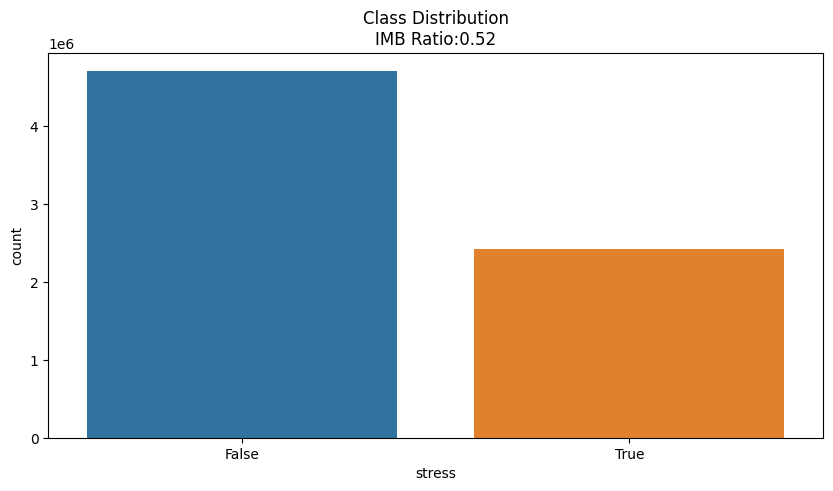

In [13]:
temp = dataset.copy()

fig = plt.figure(figsize=(10, 5))

sns.countplot(data=temp, x='stress')
_ = plt.title(f"Class Distribution\nIMB Ratio:{utils.calculate_imbalance_ratio(temp)}")

There is an imbalance between the `False` and `True`. The imbalance ratio shows that the `False` has more than double the `True` class. This is because the duration that a participant spent performing the stress inducing tasks ($\approx 18mins/participant$) is only a small fraction of the total experiment time ($\approx 60mins/participant$).

Later modelling process will need to take into account this class imbalance.

To know if a feature does have an effect of on the target `stress`, I opted to investigate if their averages changes during a `stress` vs a `non-stress` period.

I start by looking at biological features `heart_rate`, `skin_temp`, `eda`, `blood_volume_pulse`, and `inter_beat_interval`.

30/35 participants show increased in heart_rate during stress inducing tasks.
22/35 participants show increased in skin_temp during stress inducing tasks.
30/35 participants show increased in eda during stress inducing tasks.
15/35 participants show increased in blood_volume_pulse during stress inducing tasks.
7/35 participants show increased in inter_beat_interval during stress inducing tasks.


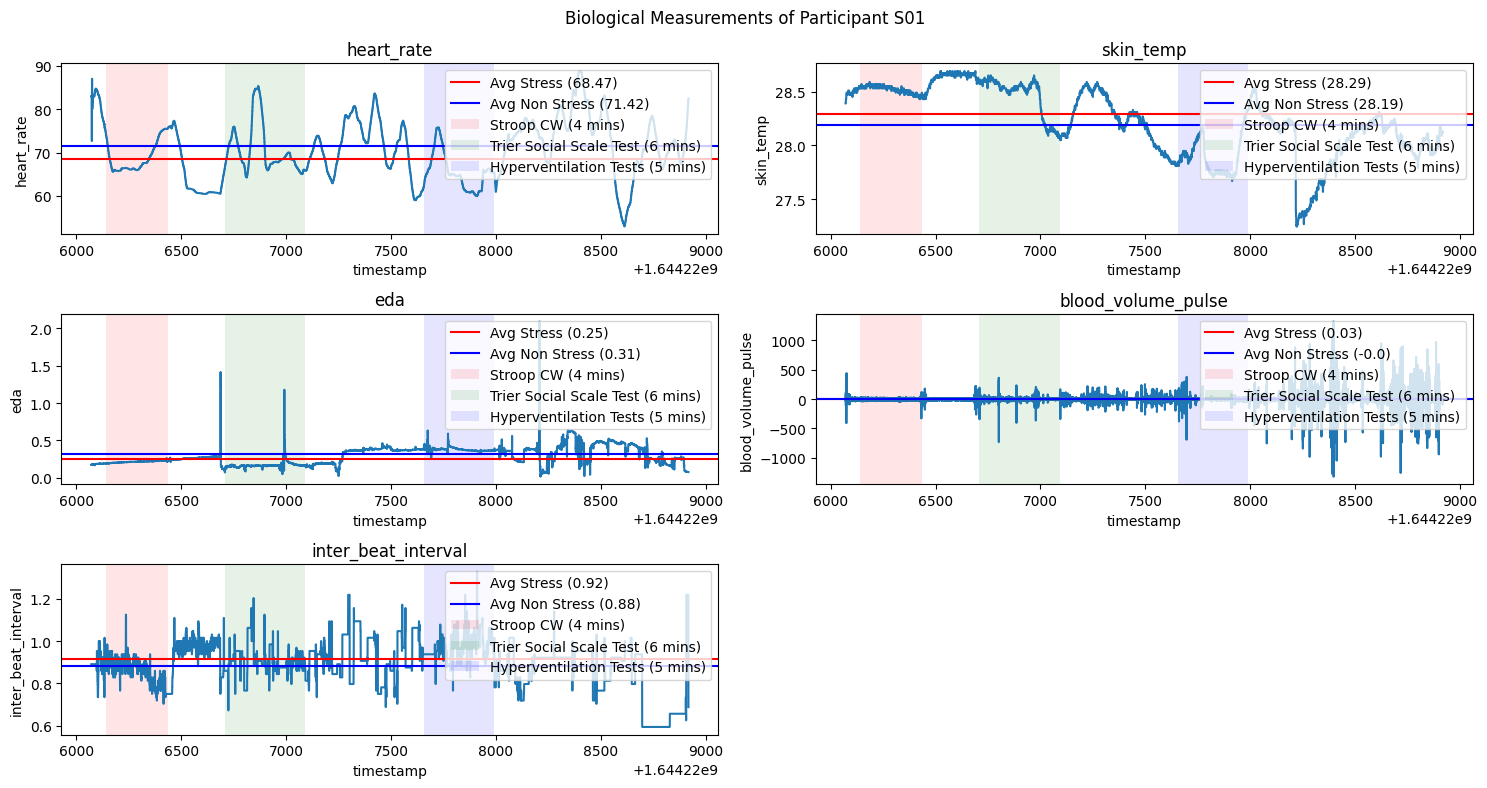

In [14]:
fig = plt.figure(figsize=(15, 8))
    
for idx, feature in enumerate(['heart_rate', 'skin_temp', 'eda', 'blood_volume_pulse', 'inter_beat_interval']):
    plt.subplot(3, 2, idx + 1)
    
    participant = 'S01'
    
    temp = dataset.copy()
    temp = temp[temp['participant'] == participant]
    
    plt.title(f"{feature}")
    utils.plot_experiment_measurement_as_timeseries(temp, feature)
    
    plt.suptitle(f"Biological Measurements of Participant {participant}")
    
    # calculate number of participant experiencing the same effect
    result = []
    
    participants = dataset['participant'].unique().tolist()
    
    for idx, participant in enumerate(participants):
        temp = dataset.copy()
        temp = temp[temp['participant'] == participant]

        avg_stress = temp[temp['stress'] == True][feature].mean()
        avg_non_stress = temp[temp['stress'] == False][feature].mean()
        
        result.append({"participant": participant, "stress": avg_stress, "non_stress": avg_non_stress})
    
    result = pd.DataFrame(result)

    result['temp'] = result['stress'] > result['non_stress']
    print(f"{result['temp'].sum()}/{len(participants)} participants show increased in {feature} during stress inducing tasks.")

fig.tight_layout(h_pad=1, w_pad=1)
plt.show()

The above shows that in majority of participants:

1. `heart_rate`, `skin_temp`, and `eda` increases during the stress inducing tasks.
2. `blood_volume_pulse` effects is not clear across participants.
3. `inter_beat_interval` decreases during stress inducing tasks.

Next, I visualise the `accel_x`, `accel_y`, and `accel_z` in a similar manner.

26/35 participants show increased in accel_x during stress inducing tasks.
18/35 participants show increased in accel_y during stress inducing tasks.
26/35 participants show increased in accel_z during stress inducing tasks.


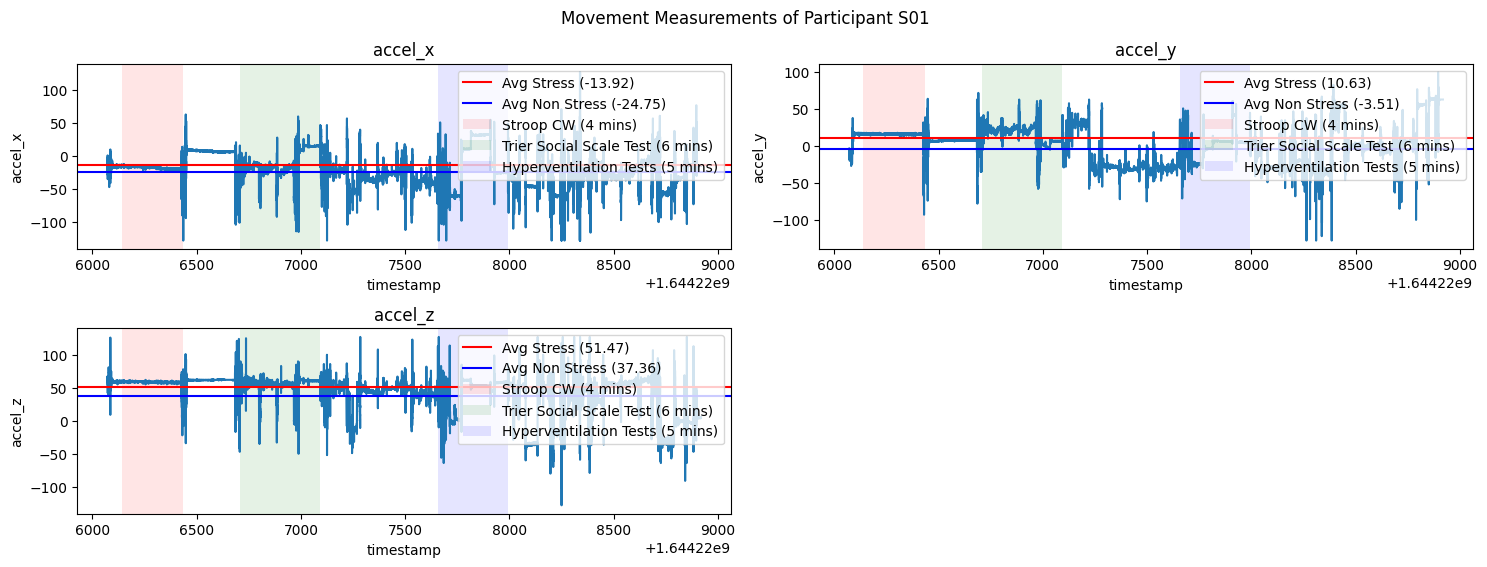

In [15]:
fig = plt.figure(figsize=(15, 8))

for idx, feature in enumerate(['accel_x', 'accel_y', 'accel_z']):
    plt.subplot(3, 2, idx + 1)

    participant = 'S01'
    temp = dataset.copy()
    temp = temp[temp['participant'] == participant]

    plt.title(f"{feature}")
    utils.plot_experiment_measurement_as_timeseries(temp, feature)

    plt.suptitle(f"Movement Measurements of Participant {participant}")

    # calculate number of participant experiencing the same effect
    result = []

    participants = dataset['participant'].unique().tolist()
    
    for idx, participant in enumerate(participants):
        temp = dataset.copy()
        temp = temp[temp['participant'] == participant]

        avg_stress = temp[temp['stress'] == True][feature].mean()
        avg_non_stress = temp[temp['stress'] == False][feature].mean()

        result.append({"participant": participant, "stress": avg_stress, "non_stress": avg_non_stress})

    result = pd.DataFrame(result)

    result['temp'] = result['stress'] > result['non_stress']
    print(f"{result['temp'].sum()}/{len(participants)} participants show increased in {feature} during stress inducing tasks.")

fig.tight_layout(h_pad=1, w_pad=1)
plt.show()

The above shows accelerometer does shows changes during stress inducing tasks.

The above time series graph shows that there are leading and trailing non-stress period for each of the experiment. Let's look at how long those periods are. This information might be useful for determining which data period can be cut off to make the class balance in the dataset.

In [16]:
temp = dataset.copy()

result = []

for participant in dataset['participant'].unique().tolist():
    t = temp[temp['participant'] == participant]
    events = t['stress'].diff()
    events = t[events == True]['timestamp'].values.tolist()
    
    result.append({
        "participant": participant,
        "leading (seconds)": len(t[t['timestamp'] < events[0]])//64, # seconds
        "trailing (seconds)": len(t[t['timestamp'] > events[-1]])//64 # seconds
    })
    
pd.DataFrame(result).describe()

,leading (seconds),trailing (seconds)
count,35.00000,35.00000
mean,636.62857,832.77143
std,139.24230,194.58781
min,69.00000,297.00000
25%,588.50000,806.00000
50%,627.00000,864.00000
75%,672.50000,938.50000
max,1032.00000,1210.00000


The above information shows that the trailing non-stress period is longer than the leading non-stress period. In addition, it shows that I can leave a minimum of `1 min` of leading and trailing non-stress period without decreasing the stress period samples.

# 5. Data Preparation <a class="anchor" id="data-preparation"></a>

To create a train/test split for this time series dataset, I opted to keep 80% of the participants for training and 20% for testing. This amounts to 28 participants for training and 7 participants for testing.

![train-test-split](./assets/train-test-split.png)

In [17]:
data = pd.read_csv(os.path.join(DATA_DIR, "clean_data.csv"))

In [18]:
participants = data['participant'].unique().tolist()
train_participants, test_participants = participants[:-7], participants[-7:] # last 7 participants is kept for testing

train_set = data[data['participant'].isin(train_participants)]
test_set = data[data['participant'].isin(test_participants)]

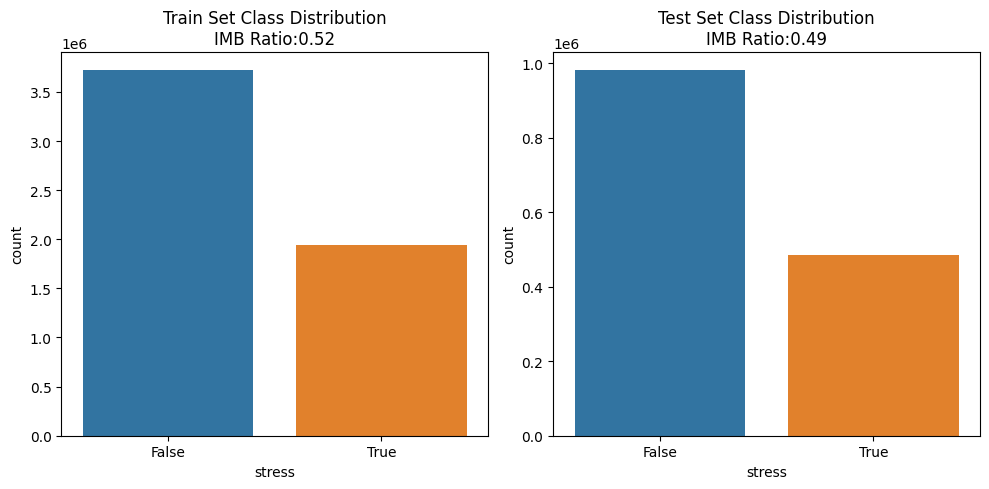

In [19]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=train_set, x='stress')
_ = plt.title(f"Train Set Class Distribution\nIMB Ratio:{utils.calculate_imbalance_ratio(train_set)}")

plt.subplot(1, 2, 2)
sns.countplot(data=test_set, x='stress')
_ = plt.title(f"Test Set Class Distribution\nIMB Ratio:{utils.calculate_imbalance_ratio(test_set)}")

fig.tight_layout(h_pad=0, w_pad=1)

The above graph shows that the split maintains the class distribution of the original set. However, this means that the class imbalance still persist in the splits. My approach to handle this is by trimming the leading and trailing non-stress period. More specifically, for each participant, I kept the maximum leading and trailing non-stress period to be `4 mins`.

![experiment-clipping](./assets/experiment-clipping.png)

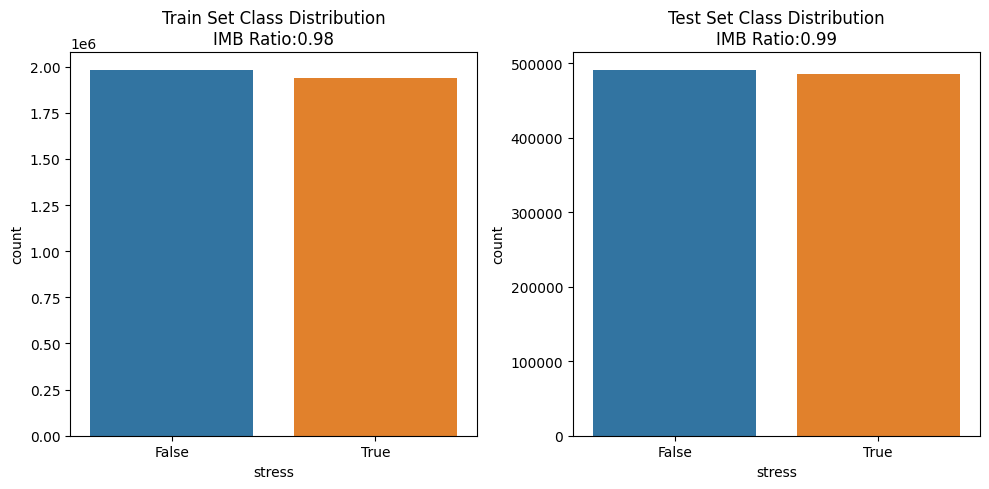

In [20]:
results = []
for participant in train_set['participant'].unique().tolist():
    clipped = utils.clip_participant_experiment_data(train_set[train_set['participant'] == participant])
    results.append(clipped)
    
train_set = pd.concat(results)

results = []
for participant in test_set['participant'].unique().tolist():
    clipped = utils.clip_participant_experiment_data(test_set[test_set['participant'] == participant])
    results.append(clipped)
    
test_set = pd.concat(results)

# plot the new distribution
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.countplot(data=train_set, x='stress')
_ = plt.title(f"Train Set Class Distribution\nIMB Ratio:{utils.calculate_imbalance_ratio(train_set)}")

plt.subplot(1, 2, 2)
sns.countplot(data=test_set, x='stress')
_ = plt.title(f"Test Set Class Distribution\nIMB Ratio:{utils.calculate_imbalance_ratio(test_set)}")

fig.tight_layout(h_pad=0, w_pad=1)

In [21]:
train_set.to_csv(os.path.join(DATA_DIR, "train.csv"), index=False)
test_set.to_csv(os.path.join(DATA_DIR, "test.csv"), index=False)

# 6. Statistical Modelling & Inference <a class="anchor" id="statistical-modelling-&-inference"></a>

Due to memory constraints, I downsampled my 64Hz train/test split data to 2Hz.

In [2]:
train_set, test_set = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))[::32], pd.read_csv(os.path.join(DATA_DIR, "test.csv"))[::32] # downsample to 4hz

## 6.1. Initial Modelling & Cross Validation <a class="anchor" id="initial-modelling-&-cross-validation"></a>

The following code cells run leave-one-participant-out cross validation using `DecisionTreeClassifier` on `558` configurations. It outputs the results into `output_filepath`.

The below code cells is used to define the different configurations that the model should try.

- `data__window_size`: The sliding window size.
- `data__stride`: The step size of the sliding window movement.
- `data__features`: The different features to include.
- `clf__criterion`: The `criterion` parameter to use with `DecisionTreeClassifier`.
- `clf__max_depth`: The `max_depth` parameter to use with `DecisionTreeClassifier`.

Additional parameters can be passed into `DecisionTreeClassifier` by added an extra key in the dictionary (e.g. `clf__splitter`).

In [3]:
output_filepath = os.path.join(OUTPUT_DIR, "dt_cv_results.csv")

In [ ]:
param_grid = {
    "data__window_size": [int(2 * i) for i in [5, 10, 20, 40, 60]],
    "data__stride": [int(2 * j) for j in [0.5, 1, 1.5, 2]],
    "data__features": utils.get_all_combinations(["ACC", "IBI", "TEMP", "EDA", "HR"]),
    "clf__criterion": ["entropy"],
    "clf__max_depth": [None, 5],
}

utils.start_cross_validation(param_grid, train_set, DecisionTreeClassifier, output_filepath)

In [82]:
results = pd.read_csv(output_filepath)

# convert data__window_size and data__stride from num of samples to seconds
results['data__window_size'] = results['data__window_size'] / 2
results['data__stride'] = results['data__stride'] / 2

The `results` variable contains a DataFrame of results from different configurations on different cross validation splits. The below code cell averages those results of different splits for each configuration.

In [83]:
avg_results = results.groupby(list(param_grid.keys()), as_index=False, dropna=False).mean(numeric_only=True)

## 6.2. Effects of Window Size and Strides

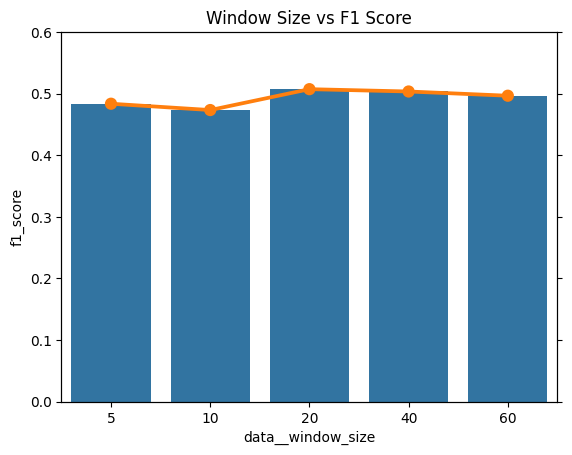

In [84]:
temp = avg_results[['data__window_size', 'f1_score']]\
        .groupby(['data__window_size'], as_index=False, dropna=False)\
        .mean()

temp['data__window_size'] = temp['data__window_size'].astype(int).astype(str)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx() # secondary y-axis

colours = sns.color_palette()

sns.barplot(data=temp, x='data__window_size', y='f1_score', color=colours[0], ax=ax1)
ax1.set_ylim(0, 0.6)

sns.pointplot(data=temp, x='data__window_size', y='f1_score', color=colours[1], ax=ax2)
ax2.set_ylim(0, 0.6)
ax2.set(yticklabels=[], ylabel=None)
ax2.tick_params(labelleft=False)
_ = plt.title("Window Size vs F1 Score")

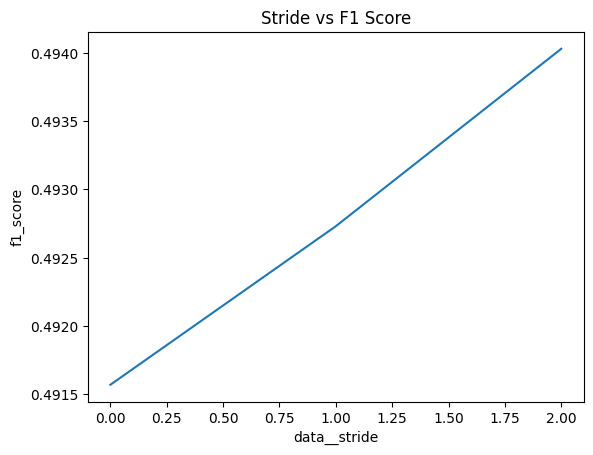

In [85]:
temp = avg_results[['data__stride', 'f1_score']]\
        .groupby(['data__stride'], as_index=False, dropna=False)\
        .mean()
temp['data__stride'] = temp['data__stride'].astype(int)

colours = sns.color_palette()

sns.lineplot(data=temp, x='data__stride', y='f1_score', color=colours[0])

_ = plt.title("Stride vs F1 Score")

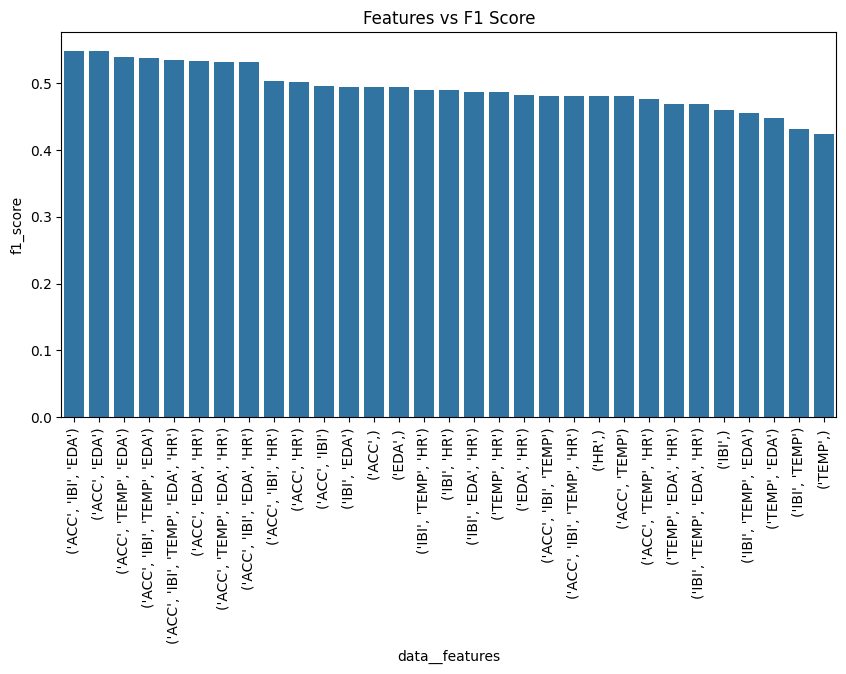

In [81]:
fig = plt.figure(figsize=(10, 5))

temp = avg_results[['data__features', 'f1_score']]\
        .groupby(['data__features'], as_index=False, dropna=False)\
        .mean()
temp = temp.sort_values(by=['f1_score'], ascending=False)

colours = sns.color_palette()

sns.barplot(data=temp, x='data__features', y='f1_score', color=colours[0])

plt.xticks(rotation=90)
_ = plt.title("Features vs F1 Score")

In [66]:
avg_results.sort_values(by=['f1_score'], ascending=False).head(n=10)

,data__window_size,data__stride,data__features,clf__criterion,clf__max_depth,accuracy,recall_score,precision_score,f1_score,tn,fp,fn,tp
434,20.00000,1.00000,"('ACC', 'EDA')",entropy,5.00000,0.60945,0.62790,0.62179,0.60028,643.96429,440.78571,403.85714,678.03571
442,20.00000,1.00000,"('ACC', 'IBI', 'EDA')",entropy,5.00000,0.60735,0.62788,0.61791,0.59851,639.17857,445.57143,403.89286,678.00000
504,20.00000,2.00000,"('ACC', 'IBI', 'EDA')",entropy,5.00000,0.61661,0.61122,0.64057,0.59767,338.21429,204.32143,210.75000,330.39286
372,20.00000,0.50000,"('ACC', 'EDA')",entropy,5.00000,0.60467,0.62614,0.61596,0.59695,1271.21429,898.39286,810.78571,1352.78571
496,20.00000,2.00000,"('ACC', 'EDA')",entropy,5.00000,0.61636,0.61047,0.63991,0.59690,338.35714,204.17857,211.17857,329.96429
380,20.00000,0.50000,"('ACC', 'IBI', 'EDA')",entropy,5.00000,0.60237,0.62608,0.61206,0.59508,1260.89286,908.71429,810.92857,1352.64286
18,5.00000,0.50000,"('ACC', 'IBI', 'TEMP', 'EDA', 'HR')",entropy,5.00000,0.62408,0.58481,0.64674,0.59192,1462.92857,736.67857,900.53571,1263.03571
310,10.00000,2.00000,"('ACC', 'EDA')",entropy,5.00000,0.61374,0.59758,0.63608,0.59009,346.35714,201.17857,218.28571,322.85714
318,10.00000,2.00000,"('ACC', 'IBI', 'EDA')",entropy,5.00000,0.61355,0.59773,0.63584,0.59005,346.07143,201.46429,218.21429,322.92857
26,5.00000,0.50000,"('ACC', 'TEMP', 'EDA', 'HR')",entropy,5.00000,0.62236,0.58143,0.64411,0.58856,1462.92857,736.67857,908.28571,1255.28571


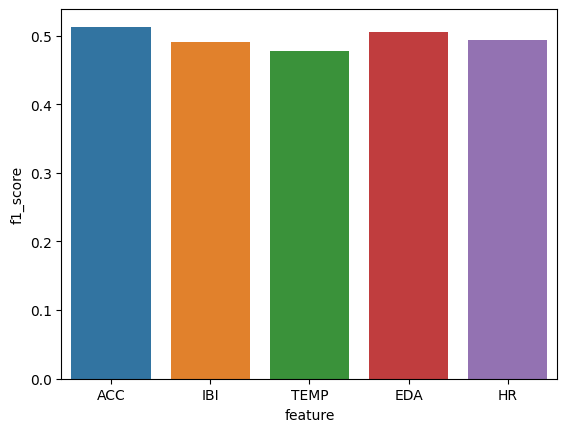

In [76]:
temp = []

for feature in ["ACC", "IBI", "TEMP", "EDA", "HR"]:
    avg_results[f"include_{feature}"] = avg_results['data__features'].apply(lambda x: feature in x)
    temp.append({"feature": feature, "f1_score": avg_results[avg_results[f"include_{feature}"]==True]['f1_score'].mean()})

temp = pd.DataFrame(temp)

_ = sns.barplot(data=temp, x='feature', y='f1_score')

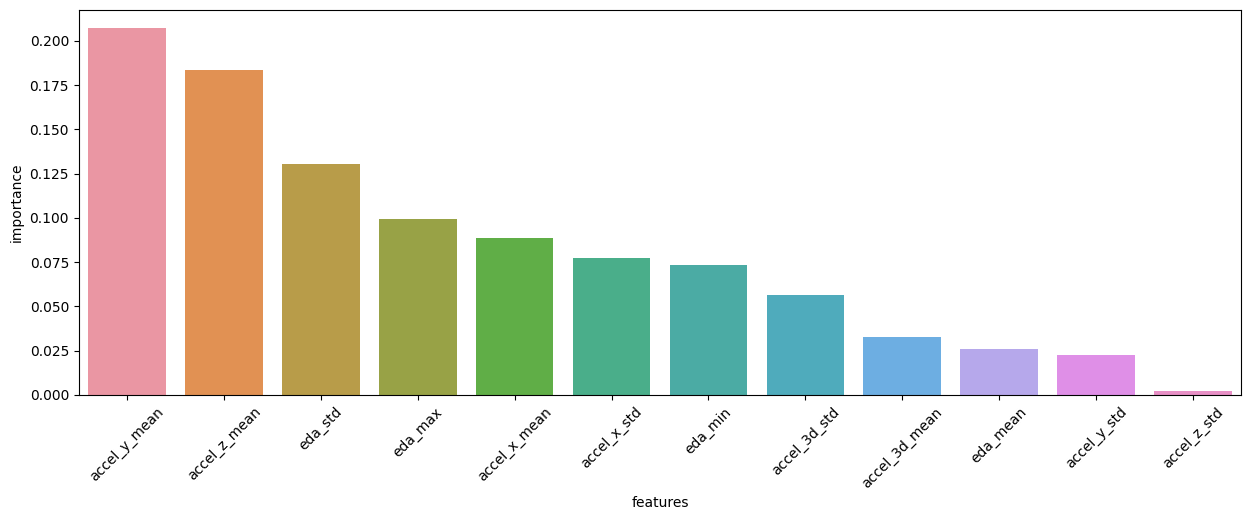

In [68]:
importances = pd.Series(clf.feature_importances_, index=X_train.columns.tolist())
importances = importances.sort_values(ascending=False)
importances = pd.DataFrame({
    "features": importances.index,
    "importance": importances.values
})

fig = plt.figure(figsize=(15, 5))

sns.barplot(data=importances, x='features', y='importance')

_ = plt.xticks(rotation=45)